In [3]:
import json
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

Device:  cuda


In [75]:
def draw_polygon_on_image(points, image, value):
  points = [(x, y) for x, y in points]
  draw = ImageDraw.Draw(image, 'RGB')
  draw.polygon(points, fill=(value, value, value))
  return image

def generate_ground_truth(ground_truth, image):
  black_image = Image.new('RGB', image.size)
  for shape in ground_truth['shapes']:
    points = shape['points']
    image = draw_polygon_on_image(points, black_image, shape['group_id'])
  return image

def process_images():
  path = r'C:\Users\topra\Documents\Jupyter\Satellite-Model\ViT\data'
  path = os.path.join(path, 'labels', '*.json')
  image_names_cand = glob.glob(path)
  image_names = []
  label_names_cand = [image_name.replace('images', 'labels').replace('.png', '.json') for image_name in image_names_cand]
  label_names = []
  for label_name, i in zip(label_names_cand, range(len(label_names_cand))):
    if os.path.exists(label_name):
      image_name = label_name.replace('labels', 'images').replace('.json', '.png')
      image_names.append(image_name)
      label_names.append(label_name)
  for image_name, label_name in zip(image_names, label_names):
    image = Image.open(image_name)
    with open(label_name, 'r') as file:
      ground_truth = json.load(file)
      ground_truth_image = generate_ground_truth(ground_truth, image)
      ground_truth_image.save(image_name.replace('images', 'truth'))

process_images()

In [4]:
class SatelliteDataset(Dataset):
  def __init__(self, image_folder, truth_folder, transform_data=None, transform_truth=None):
    path = r'C:\Users\topra\Documents\Jupyter\Satellite-Model\ViT\data'
    image_path = os.path.join(path, image_folder, '*.png')
    truth_path = os.path.join(path, truth_folder, '*.png')
    image_names_cand = glob.glob(image_path)
    truth_images_cand = glob.glob(truth_path)
    self.image_names = []
    self.truth_images = []
    for image_name, i in zip(image_names_cand, range(len(image_names_cand))):
      truth_name = image_name.replace('images', 'truth')
      if truth_name in truth_images_cand:
        self.image_names.append(image_name)
        self.truth_images.append(truth_name)
    self.transform_data = transform_data
    self.transform_truth = transform_truth

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image = Image.open(self.image_names[idx])
    truth = Image.open(self.truth_images[idx])
    if self.transform_data:
      image = self.transform_data(image)
    if self.transform_truth:
      truth = self.transform_truth(truth)
    return image, truth

transform_data = transforms.Compose([
  transforms.ToTensor()
])

transform_truth = transforms.Compose([
  transforms.ToTensor(),
  transforms.Grayscale()
])

dataset = SatelliteDataset('images', 'truth', transform_data=transform_data, transform_truth=transform_truth)

In [9]:
import torch
import torch.functional as F
import torch.nn as nn

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(mid_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(2),
      DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=False):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits


class PatchPositionalEmbedding(nn.Module):
  def __init__(self,
               channels: int=3,
               patch_size: int=128,
               max_len: int=512):
    super(PatchPositionalEmbedding, self).__init__()

    # Layers
    self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size, padding=0)       # (batch, C*patch_size*patch_size, num_tokens)
    self.embed = nn.Parameter(torch.randn(1, max_len, channels*patch_size*patch_size))  # (batch, max_len, C*patch_size*patch_size)
    self.pred = torch.zeros(1, 1, channels*patch_size*patch_size)                       # (batch, max_len, C*patch_size*patch_size)
      
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.unfold(x)
    x = torch.concat([x.transpose(1, 2), self.pred], dim=1)
    
    # Dynamic interpolation of embeddings to match the input size
    if x.size(1) > self.embed.size(1):
      embed = F.interpolate(self.embed, size=(x.size(1), x.size(2)), mode='linear', align_corners=False)
    else:
      embed = self.embed[:, :x.size(1)]
        
    return x + embed

class PyramidState(nn.Module):
  def __init__(self,
               channels_in: int=3,
               channels_out: int=3,
               patch_size: int=128,
               max_len: int=512):
               )

class PyramidVisionTransformer(nn.Module):
	def __init__(self,
               channels: int=3,
               patch_size: int=128,
               max_len: int=512,
               num_layers: int=12,
               sub_layers: int=4):
		super(PyramidVisionTransformer, self).__init__()
		self.patches = nn.Sequential(*[PatchPositionalEmbedding(channels=channels, patch_size=patch_size//(2**(i + 1)), max_len=max_len) for i in range(num_layers)])
		self.layers = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=channels*patch_size*patch_size//(2**(2*i + 1)), nhead=8, dim_feedforward=2048) for i in range(sub_layers)])
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		for patch, layer in zip(self.patches, self.layers):
			x = patch(x)
			x = layer(x)
		return x


class ScaledDotProductAttention(nn.Module):
    def __init__(self,
                channels: int=3,
                patch_size: int=128):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,
                v: torch.Tensor,
                k: torch.Tensor,
                q: torch.Tensor) -> torch.Tensor:
        x = torch.dot(q, k)
        x = x / (q.size(-1) ** 0.5)
        x = self.softmax(x)
        x = torch.matmul(x, v)
        return x


# class MultiHeadAttention(nn.Module):
#   def __init__(self,
#                channels: int=3,
#                patch_size: int=128,
#                h: int=8):
#     super(MultiHeadAttention, self).__init__()
#     self.linear_v = [nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size*h) for _ in range(h)]
#     self.linear_k = [nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size*h) for _ in range(h)]
#     self.linear_q = [nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size*h) for _ in range(h)]
#     self.scaled_dot = [ScaledDotProductAttention(channels=channels, patch_size=patch_size) for _ in range(h)]
#     self.linear_out = nn.Linear(channels*patch_size*patch_size*h, channels*patch_size*patch_size)

#   def forward(self, x: torch.Tensor) -> torch.Tensor:
#     y = []
#     for i in range(h):
#       v = self.linear_v[i](x)
#       k = self.linear_k[i](x)
#       q = self.linear_q[i](x)
#       y.append(self.scaled_dot[i](v, k, q))
#     x = torch.concat(y, dim=-1)
#     x = self.linear_out(x)
#     return x


# class TransformEncoder(nn.Module):
# 	def __init__(self,
# 							 channels: int=3,
# 							 patch_size: int=128,
# 							 max_len: int=512):
# 		super(TransformEncoder, self).__init__()
# 		self.norm_1 = nn.LayerNorm(channels*patch_size*patch_size)
# 		self.attention = MultiHeadAttention()
# 		self.norm_2 = nn.LayerNorm(channels*patch_size*patch_size)
# 		self.mlp = nn.Sequential(
# 			nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size),
# 			nn.Sigmoid(),
# 			nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size),
# 			nn.Sigmoid(),
# 			nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size),
# 			nn.Sigmoid(),
# 			nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size),
# 			nn.Sigmoid(),
# 			nn.Linear(channels*patch_size*patch_size, channels*patch_size*patch_size)
# 		)

# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		"""_summary_
		
# 		Args:
# 			x (torch.Tensor): (batch, num_tokens, C*patch_size*patch_size)

# 		Returns:
# 			torch.Tensor: (batch, num_tokens, C*patch_size*patch_size)
# 		"""
# 		x_2 = self.norm_1(x)
# 		x_2 = self.attention(x_2)
# 		x_2 = x_2 + x
# 		x = x_2
# 		x_2 = self.norm_2(x)
# 		x_2 = self.mlp(x_2)
# 		x_2 = x_2 + x
# 		return x_2


# class VisionTransformer(nn.Module):
    def __init__(self,
                 channels: int=3,
                 patch_size: int=128,
                 max_len: int=512,
                 num_layers: int=12):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchPositionalEmbedding(channels=channels, patch_size=patch_size, max_len=max_len)
        self.layers = nn.Sequential(*[TransformEncoder(channels=channels, patch_size=patch_size, max_len=max_len) for _ in range(num_layers)])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        x = self.layers(x)
        
        return x

torch.Size([3, 512, 512]) -> torch.Size([1, 1025, 768])
torch.Size([1, 1025, 768]) -> torch.Size([1, 3, 512, 512])


Text(0.5, 1.0, 'Extracted Image')

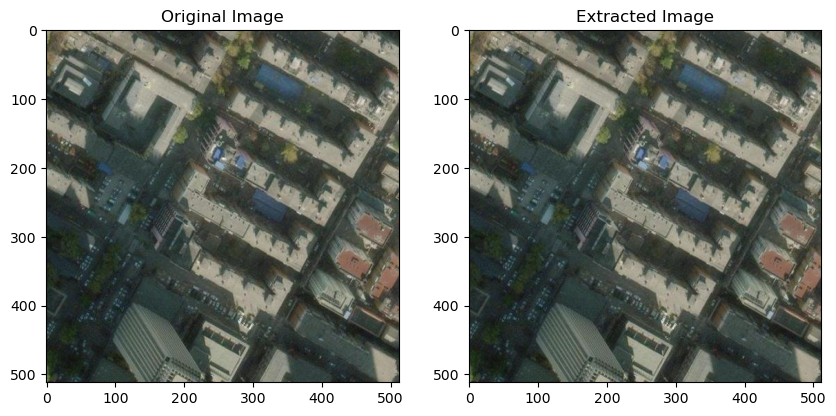

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch

class PatchPositionalEmbedding(nn.Module):
  def __init__(self,
               channels: int=3,
               patch_size: int=128,
               pos_embed_size: int=512):
    super(PatchPositionalEmbedding, self).__init__()

    # Layers
    self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size, padding=0)              # (batch, C*patch_size*patch_size, num_tokens)
    self.embed = nn.Parameter(torch.randn(1, pos_embed_size, channels*patch_size*patch_size))  # (batch, token_len, C*patch_size*patch_size)
    self.pred = torch.zeros(1, 1, channels*patch_size*patch_size)                              # (batch, token_len+1, C*patch_size*patch_size)
      
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.unfold(x)
    x = torch.concat([x.transpose(1, 2), self.pred], dim=1)
    embed = F.interpolate(self.embed.permute(0, 2, 1), size=x.size(1), mode='linear', align_corners=False).permute(0, 2, 1) # (batch, token_len+1, C*patch_size*patch_size)
    return x + embed/200.0

class PatchPositionalExtractor(nn.Module):
  def __init__(self,
               channels: int=3,
               patch_size: int=128,
               output_size: int=512):
    super(PatchPositionalExtractor, self).__init__()
    self.channels = channels
    self.patch_size = patch_size
    self.output_size = output_size
    self.fold = nn.Fold(output_size, kernel_size=patch_size, stride=patch_size) # (batch, C*patch_size*patch_size, num_tokens)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    token_len = x.size(1) - 1
    assert self.output_size % self.patch_size == 0, "Output size must be divisible by patch size"
    x = x[:, :(self.output_size**2)//(self.patch_size**2), :] # (batch, num_tokens, C*patch_size*patch_size)
    x = self.fold(x.permute(0, 2, 1)) # (batch, C*patch_size*patch_size, output_size**2)
    return x

image_size = 512
patch_size = 16
channels = 3

image, truth = dataset[0] # Get the first image and its ground truth
image = transforms.Resize((image_size, image_size))(image)
truth = transforms.Resize((image_size, image_size))(truth)

input_shape = image.shape
patch_embedding = PatchPositionalEmbedding(channels=channels, patch_size=patch_size, pos_embed_size=512)
x = patch_embedding.forward(image.unsqueeze(0))
patched_shape = x.shape
print(f"{input_shape} -> {patched_shape}")    

patch_extractor = PatchPositionalExtractor(channels=channels, patch_size=patch_size, output_size=image_size)
x = patch_extractor.forward(x)
extracted_shape = x.shape
print(f"{patched_shape} -> {extracted_shape}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[1].imshow(x[0].permute(1, 2, 0).detach().numpy())
ax[1].set_title("Extracted Image")

c:\Users\topra\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


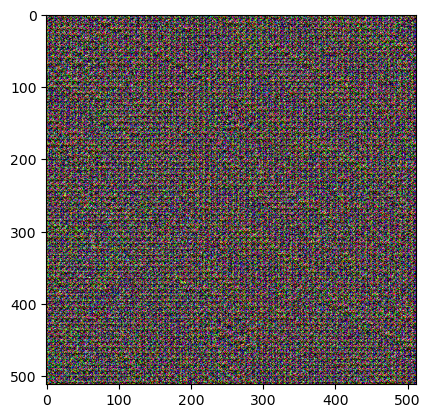

In [82]:
import torch.nn as nn
import matplotlib.pyplot as plt

class Model(nn.Module):
  def __init__(self,
               patch_size: int=8,
               channels: int=3):
    super(Model, self).__init__()
    self.embed = PatchPositionalEmbedding(channels=channels, patch_size=patch_size)
    self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=patch_size*patch_size*channels, nhead=8), num_layers=6)
    self.extract = PatchPositionalExtractor(channels=channels, patch_size=patch_size, output_size=512)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.embed(x)
    x = self.transformer(x)
    x = self.extract(x)
    return x
 
model = Model()
image, truth = dataset[0]
parameter_count = sum(p.numel() for p in model.parameters())
output = model.forward(image.unsqueeze(0))
plt.imshow(output[0].permute(1, 2, 0).detach().numpy())